## Load API keys needed for Elsevier and Dropbox

Set the API keys in [api_keys.ipynb](api_keys.ipynb).

In [1]:
%run api_keys.ipynb

Keys loaded from 'api_keys.py'


### Connect to Scopus

In [2]:
%run scopus.ipynb

Files in storage, top level (3): json, test, xml


## Obtain records

In [3]:
scopus_query = "tourism+AND+innovation"

In [4]:
data = scopus_retrive(scopus_query, save_to_file='tmp_all.csv')
print('Documents loaded: {}'.format(len(data)))

200/2142
400/2142
600/2142
800/2142
1000/2142
1200/2142
1400/2142
1600/2142
1800/2142
2000/2142
2142/2142
0
200
400
600
800
1000
1200
1400
1600
1800
2000
Documents loaded: 2142


## Preprocess

In [5]:
%run preprocessing.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomazc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tomazc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
ignore_words = [
    "finding", "research", "purpose", "study", "methodology", "result", 
    "analysis", "method", "paper", "literature", "tourism", "tourist", "innovation",
    "also", "within", "whereas", "would"
]

In [7]:
documents_tokens, data_preprocessed, bigram_lexicon = preprocess(data, to_ignore=ignore_words, save_to_file='tmp_preprocessed.csv')
print('Documents kept after preprocessing: {}'.format(len(documents_tokens)))

Documents kept after preprocessing: 2080


## Basic statistics

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

### Word Frequencies

Find most frequent words in the corpus.

In [9]:
fdist = word_frequencies(documents_tokens)

Change `show_top_n` to adjust the number of words to display.

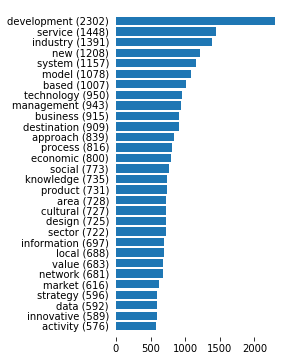

In [10]:
show_top_n = 30

# calc
mc = fdist.most_common(show_top_n)

# plot
mc = mc[::-1] ; ws, fs = zip(*mc) ; ws = ['{} ({})'.format(w, f) for w, f in mc]
plt.figure(figsize=(3, 6*show_top_n/30))
plt.box(False); plt.tick_params(top='off', bottom='on', left='off', right='off', labelleft='on', labelbottom='on')
plt.barh(range(len(ws)), fs) ; plt.yticks(range(len(ws)), ws); plt.ylim(-1, len(ws));

### Context of words

Find common contexts (co-occurring words) where the words from the list appear.

In [11]:
word_list = ['industry', 'technology']

context = word_contexts(documents_tokens, word_list, num=20)

smart_smart new_become development_development
communication_application


## Topic discovery

In [12]:
%run "Topic Modeling/pyldavis.ipynb"

### Show topics and most frequently used words in each topic
Set `num_topics` to the expected number of topics in the corpus.

Set `num_words` to control the number of ***most frequent*** words listed for each topic.

In [13]:
num_topics = 7
num_words = 10

corpus, dictionary, ldamodel = pyldavis_prep(documents_tokens, num_topics=num_topics, num_words=num_words)

Topic 1:
   "new": 0.013
   "marketing": 0.013
   "development": 0.012
   "industry": 0.011
   "market": 0.010
   "product": 0.008
   "innovative": 0.008
   "article": 0.007
   "policy": 0.007
   "strategy": 0.007
Topic 2:
   "new": 0.012
   "market": 0.008
   "change": 0.007
   "economic": 0.007
   "space": 0.006
   "people": 0.006
   "production": 0.006
   "international": 0.005
   "public": 0.005
   "political": 0.005
Topic 3:
   "development": 0.009
   "service": 0.008
   "model": 0.007
   "business": 0.007
   "industry": 0.006
   "system": 0.006
   "based": 0.006
   "technology": 0.005
   "knowledge": 0.005
   "approach": 0.005
Topic 4:
   "development": 0.014
   "industry": 0.009
   "area": 0.008
   "process": 0.008
   "new": 0.006
   "economic": 0.006
   "rural": 0.006
   "agricultural": 0.005
   "approach": 0.005
   "community": 0.005
Topic 5:
   "district": 0.022
   "mortality": 0.013
   "maternal": 0.013
   "health": 0.012
   "year": 0.009
   "delivery": 0.009
   "hospital": 

### Interactive visualization of topics

The visualization shows topics as circles in a 2D plot. This is an approximation of topic similarity. The more similar two topics are, the closer they will be in the plot. The size of the circle corresponds to the presence of the topic in the corpus.

The visualization also shows the top 30 ***most relevant*** terms (words) for each topic. If a word is frequent in a topic, but also in the entire corpus, it will get a lower relevance score than a word that is frequent in a topic alone. 

***Relevance*** of a word in a topic is a weighted measure of the word probability within the topic and the word lift (the ratio of the word probability within the topic to its probability in the entire corpus). 

***Saliency*** refers to the importance of each word for a topic.


How to interact with the visualization:
1. Select a topic by clicking on a circle in the plot or by selecting a topic number in the control area at the top.

2. On the right, you see the most relevant terms for the selected topic. Adjust the relevance slider. For `lambda = 0` it is equal to the lift of the word, for `lambda = 1` it is equal to probability of the word within the topic.

3. If you click on a word in the histogram on the right, topic circles will resize according to the ***saliency*** of the term in the topic.

In [14]:
pyldavis_vis(corpus, dictionary, ldamodel, save_to_html='tmp.html')

## Cluster documents and topics

Add topic vectors and generate a clustering of documents.

In [15]:
%run "Topic Modeling/visualization.ipynb"

In [16]:
topic_vectors = add_topics_vector(corpus, ldamodel)
data_preprocessed_vectors = pd.concat([data_preprocessed, topic_vectors], axis=1)
data_preprocessed_vectors.to_csv('tmp_preprocessed_vectors.csv', index=False)

Visualize with heatmaps.

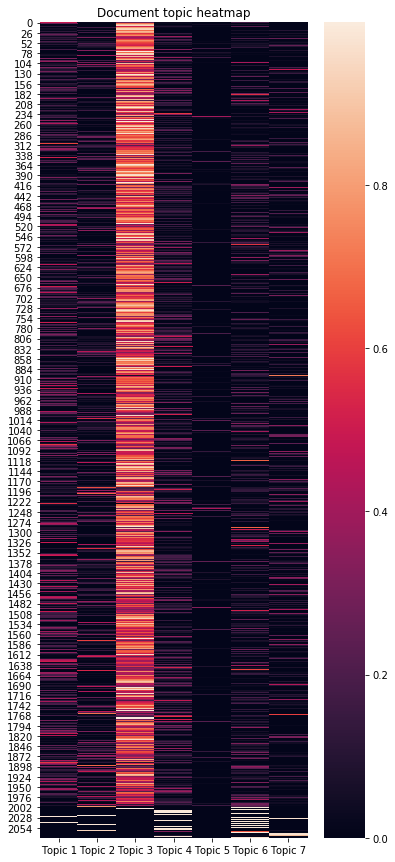

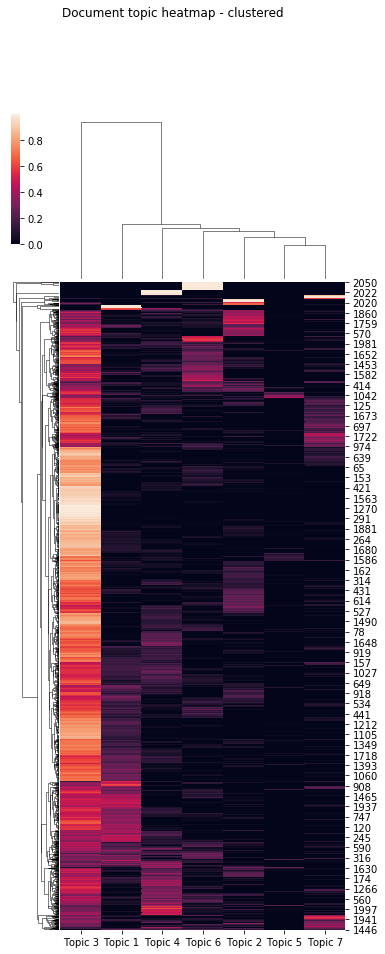

In [17]:
hm, cm = visualize(topic_vectors)